In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from torchvision.datasets import CIFAR10
import torch


def plot_client_data(settings_ids, dataset, model, n_clients, dist):
    train_data = CIFAR10(root='data', train=True)
    train_data.targets = torch.tensor(train_data.targets)
    fig, ax = plt.subplots(len(settings_ids), 1, figsize=(16, 10))

    for j, settings_id in enumerate(settings_ids):

        settings_path = f"./settings/{dataset}_{model}_c{n_clients}_{dist}_{settings_id}"
        local_indices = []
        with open(f"{settings_path}/data_splits.npy", "rb") as f:
            public_indices = np.load(f)
            try:
                while True:
                    local_indices.append(np.load(f))
            except:
                pass
        
        client_targets = [train_data.targets[indices].tolist() for indices in local_indices]
        n_clients = len(client_targets)
        n_classes = 10

        label_count_matrix = np.array([[np.sum(np.array(client_targets[i]) == c) for c in range(10)] for i in range(n_clients)])
        print(label_count_matrix)
        data_dict = {}
        for i in range(n_classes):
            data_dict[f"label_count{i}"] = label_count_matrix[:, i]

        df = pd.DataFrame(data_dict)

        #df.plot(ax=ax[j], kind='bar', stacked=True, rot=0)
        #ax[j].get_legend().remove()
    #ax[0].legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], mode="expand", ncol=10, bbox_to_anchor=(0,1.02,1,0.15), loc="upper left")
    #plt.show()

def plot_test_public_data(settings_ids, dataset, model, n_clients, dist):

    settings_path = f"./settings/{dataset}_{model}_c{n_clients}_{dist}_{settings_ids[0]}"
    with open(f"{settings_path}/data_splits.npy", "rb") as f:
        public_indices = np.load(f)

    test_data = CIFAR10(root='data', train=False)
    train_data = CIFAR10(root='data', train=True)
    train_data.targets = torch.tensor(train_data.targets)
    test_data.targets = torch.tensor(test_data.targets)
    test_public_targets = [test_data.targets.tolist()]
    test_public_targets.append(train_data.targets[public_indices].tolist())
    
    n_classes = 10
    label_count_matrix = np.array([[np.sum(np.array(targets) == c) for c in range(n_classes)] for targets in test_public_targets])

    data_dict = {}
    for i in range(n_classes):
        data_dict[f"label_count{i}"] = label_count_matrix[:, i]

    fig, ax = plt.subplots(figsize=(12, 8))
    df = pd.DataFrame(data_dict, index=["Test data", "Public data"])
    df.plot(ax=ax, kind='bar', stacked=True, rot=0)
    ax.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], mode="expand", ncol=10, bbox_to_anchor=(0,1.01,1,0.1), loc="upper left")
    ax.tick_params(axis='both', which='major', labelsize=18)
    plt.show()    

def plot_client_training(settings_ids, dataset, alg, weight_scheme, loss=None, student_model=None):    
    student_model = student_model + "_" if student_model is not None else ""
    loss = loss + "_" if loss is not None else ""
    
    fig, ax = plt.subplots(2, len(settings_ids), figsize=(15,6))
    for i, setting_id in enumerate(settings_ids):
        results_path = f"./results/{dataset}/{alg}/{setting_id}_{student_model}{loss}w{weight_scheme}"
        client_accs = []
        with open(f"{results_path}/client_accuracy.npy", "rb") as f:
            try:
                while True:
                    client_accs.extend([np.load(f)])
            except:
                pass

        client_losses = []
        with open(f"{results_path}/client_loss.npy", "rb") as f:
            try:
                while True:
                    client_losses.extend([np.load(f)])
            except:
                pass

        for accs in client_accs:
            ax[0][i].plot(accs)

        for losses in client_losses:
            ax[1][i].plot(losses)
    plt.show()  

def plot_student_results(dataset, alg, settings_ids, n_pub, model, loss, weight_scheme):
    fig, ax = plt.subplots(len(settings_ids), len(n_pub), figsize=(20,10))
    test_acc_lists = [[] for _ in range(len(n_pub))]
    ensemble_test_acc = [[] for _ in range(len(settings_ids))]

    for i, setting_id in enumerate(settings_ids):
        results_path = f"./results/{dataset}/{alg}/{setting_id}_{model}_{loss}_w{weight_scheme}"
        for j, n in enumerate(n_pub):
            with open(f"{results_path}/student_train_results{n}.npy", "rb") as f:
                train_accs = np.load(f)
                train_losses = np.load(f)
                val_accs = np.load(f)
                val_losses = np.load(f)

            with open(f"{results_path}/student_test_results_{n}.npy", "rb") as f:
                test_results = np.load(f)

            ax[i][j].plot(train_accs)
            ax[i][j].plot(val_accs)
            #ax[i][j].set_ylim([0,70])
            test_acc_lists[j].append(test_results[0])
            
        with open(f"{results_path}/ensemble_test_acc.npy", "rb") as f:
                ensemble_test_acc[i] = np.load(f)[0]
        
    plt.show()
    print("Test accuracy \n\n")
    print("{:<15} {:<10} {:<10} {:<10} {:<10} {:<10} | {:<10}".format('Run\Public size', n_pub[0], n_pub[1], n_pub[2], n_pub[3], n_pub[4], 'Ensemble acc'))
    for run in range(len(settings_ids)):
        print("{:<15} {:<10.2f} {:<10.2f} {:<10.2f} {:<10.2f} {:<10.2f} | {:<10.2f} ".format(run, 
                                                  test_acc_lists[0][run],
                                                  test_acc_lists[1][run],
                                                  test_acc_lists[2][run],
                                                  test_acc_lists[3][run],
                                                               test_acc_lists[4][run],
                                                    ensemble_test_acc[run]))
    print("")
    print("{:<15} {:<10.2f} {:<10.2f} {:<10.2f} {:<10.2f} {:<10.2f}".format('Mean',
                                                     np.mean(test_acc_lists[0]),
                                                     np.mean(test_acc_lists[1]),
                                                     np.mean(test_acc_lists[2]),
                                                     np.mean(test_acc_lists[3]),
                                                                np.mean(test_acc_lists[4])))

def print_fedavg_test_results(dataset, settings_ids):
    fig, ax = plt.subplots(1, 2, figsize=(15,6))
    test_acc_list = []
    for i, setting_id in enumerate(settings_ids):
        results_path = f"./results/{dataset}/fedavg/{setting_id}_w0"

        with open(f"{results_path}/fedavg_test_results.npy", "rb") as f:
            test_accs = np.load(f)
            test_losses = np.load(f)

        ax[0].plot(test_accs)
        ax[1].plot(test_losses)
        test_acc_list.append(test_accs[-1])
    ax[0].set_ylabel("Accuracy")
    ax[0].set_xlabel("Communication round")
    ax[1].set_ylabel("Loss")
    ax[1].set_xlabel("Communication round")
    plt.show()
    print("{:<8} {:<10}".format('Run', 'Test accuracy'))
    for run in range(len(settings_ids)):
        print("{:<8} {:<10}".format(run, test_acc_list[run]))
    print("")
    print("{:<8} {:<10.2f}".format('Mean', np.mean(test_acc_list)))

# Data distribution

In [1]:
# settings_ids = ["dpp", "qre", "vvr", "xsf", "yzu"]
# distribution = "iid"
settings_ids = ["got", "hhk", "kih", "sgk", "zkc"]
distribution = "niid0.1"

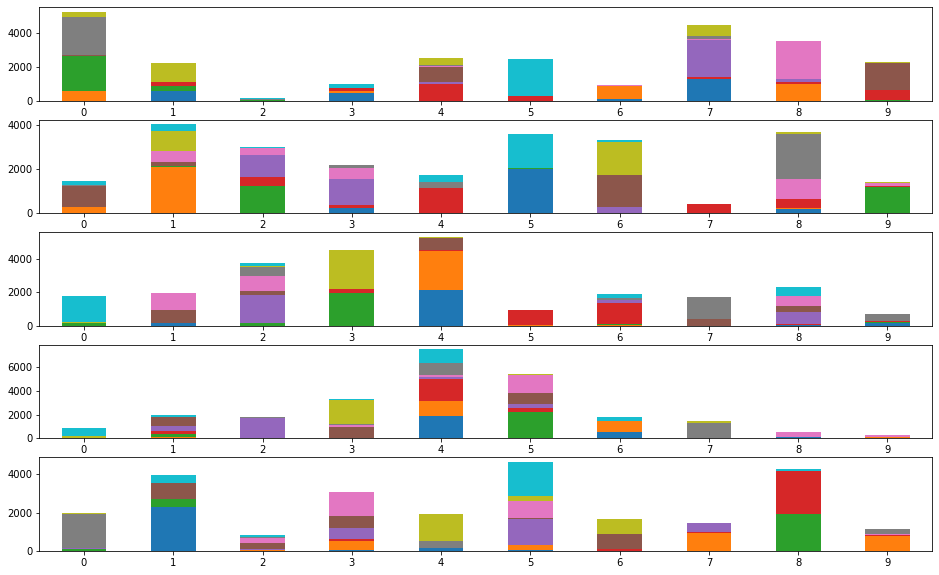

In [4]:
plot_client_data(settings_ids, "cifar10", "resnet", 10, distribution)

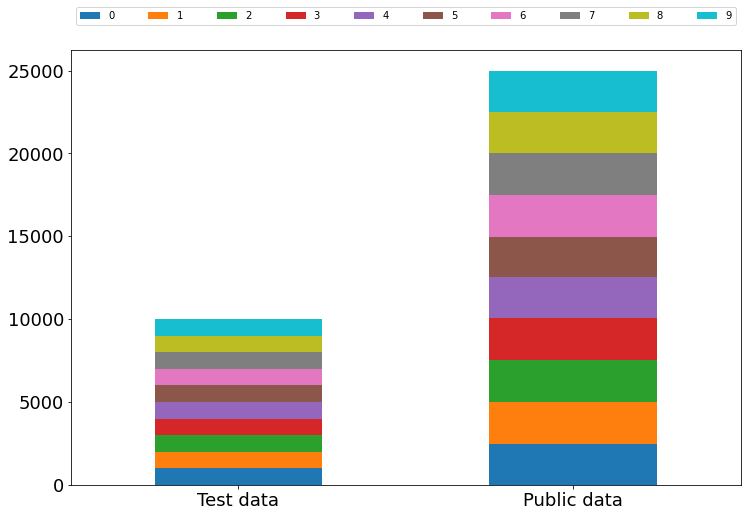

In [4]:
plot_test_public_data(settings_ids, "cifar10", "resnet", 10, distribution)

# FedAVG
```
class Cifar10_Resnet(nn.Module):
    def __init__(self):
        super(Cifar10_Resnet, self).__init__()
        base = resnet18(pretrained=False)
        self.base = nn.Sequential(*list(base.children())[:-1])
        in_features = base.fc.in_features
        self.drop = nn.Dropout()
        self.final = nn.Linear(in_features, 10)
    
    def forward(self,x):
        x = self.base(x)
        x = self.drop(x.view(-1,self.final.in_features))
        return self.final(x)
```
Centralized model ~ 56 % accuracy

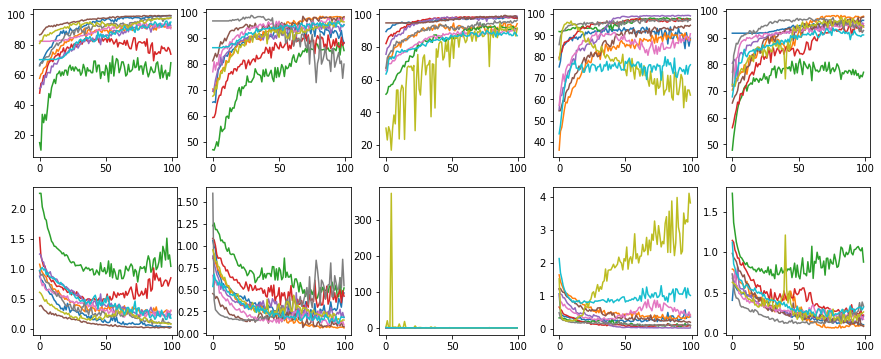

In [5]:
plot_client_training(settings_ids, "cifar10", "fedavg", 0)

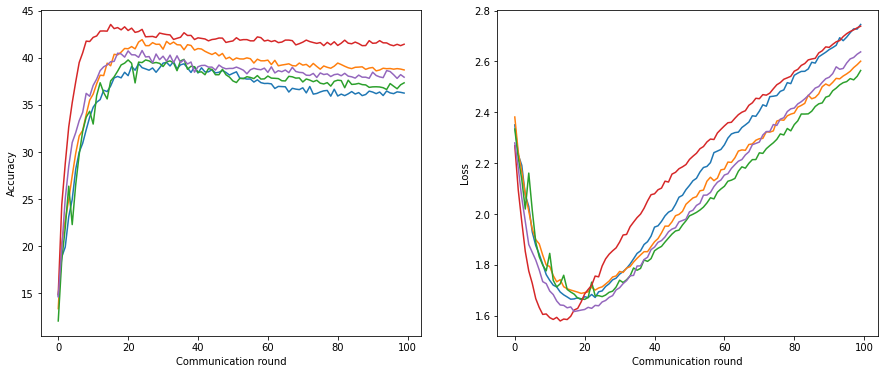

Run      Test accuracy
0        36.25     
1        38.71     
2        37.34     
3        41.44     
4        37.94     

Mean     38.34     


In [14]:
print_fedavg_test_results("cifar10", settings_ids)

# FedED

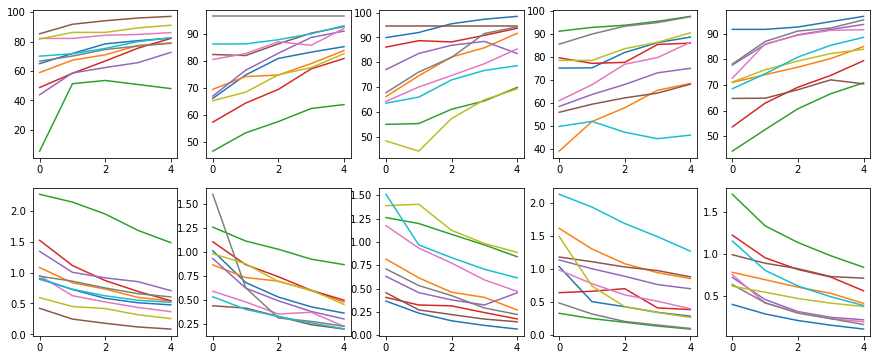

In [8]:
plot_client_training(settings_ids, "cifar10", "feded", 0, "mse", "resnet")

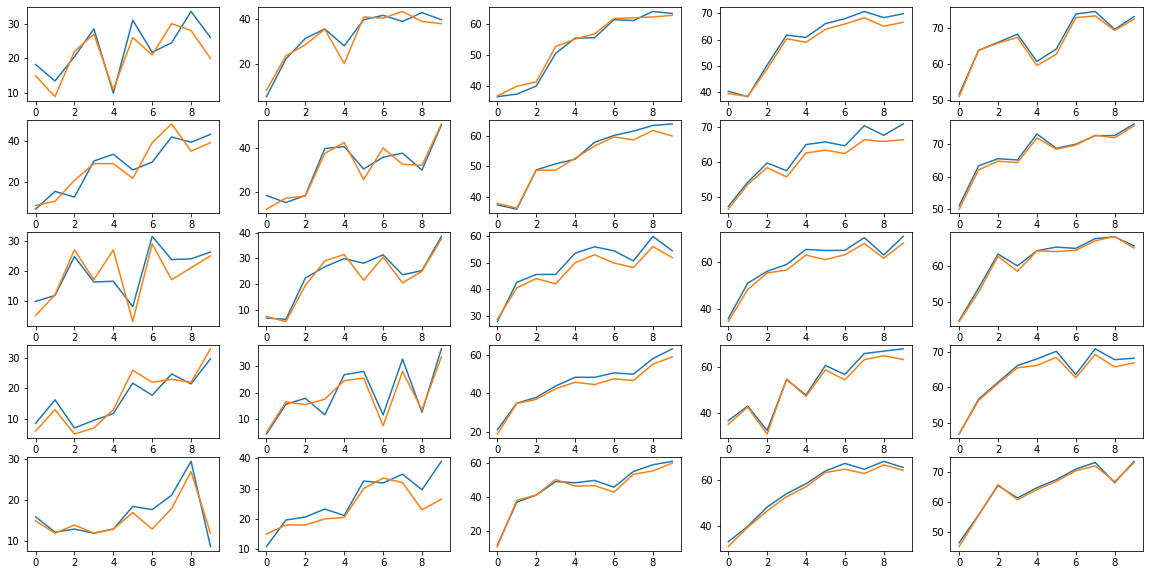

Test accuracy 


Run\Public size 500        1000       5000       10000      25000      | Ensemble acc
0               13.58      18.64      26.73      31.01      33.15      | 35.62      
1               18.17      21.72      28.13      31.06      35.33      | 37.91      
2               12.63      16.07      25.91      29.27      30.63      | 35.13      
3               17.32      20.90      32.50      37.68      40.84      | 41.29      
4               11.29      21.87      28.63      31.24      35.29      | 37.73      

Mean            14.60      19.84      28.38      32.05      35.05     


In [9]:
plot_student_results("cifar10", "feded", settings_ids, [500, 1000, 5000, 10000, 25000], "resnet", "mse", 0)

# FedED weight scheme 1

$$
  \mathbf{\hat{z}}_c = \sum_{k\in\mathcal{K}_t} \omega^c_k \mathbf{z}^k_c, \quad \omega^k_c = \frac{N_c^k}{\sum_{k\in\mathcal{K}_t} N_c^k}
$$

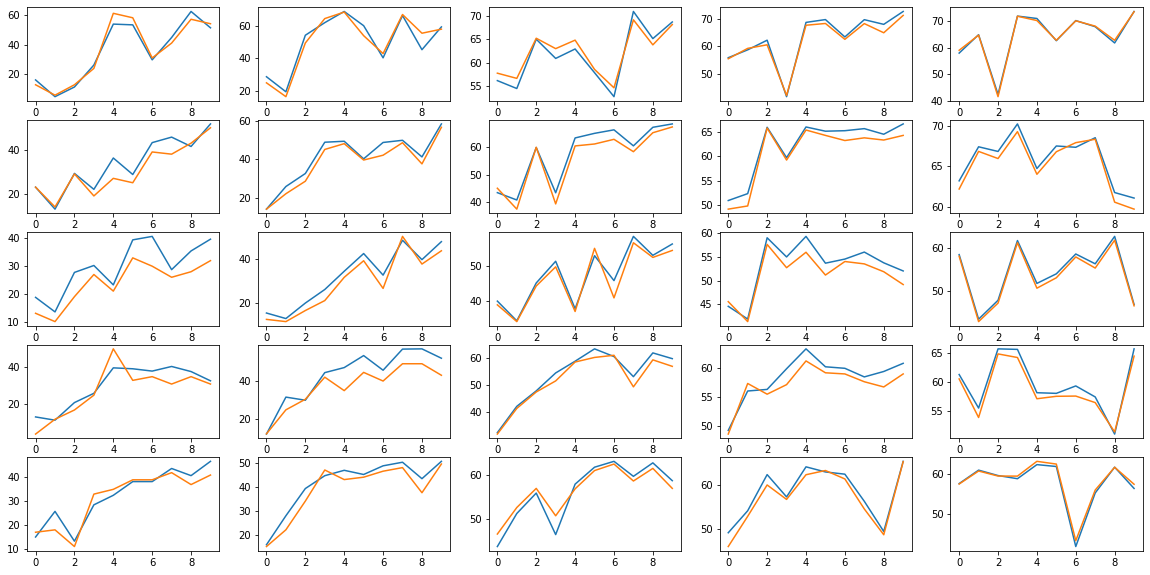

Test accuracy 


Run\Public size 500        1000       5000       10000      25000      | Ensemble acc
0               19.77      19.87      24.36      24.36      23.87      | 28.07      
1               16.22      19.68      28.66      28.12      27.15      | 34.54      
2               21.70      25.16      28.89      30.51      28.18      | 38.32      
3               17.41      22.14      28.71      26.29      31.79      | 34.87      
4               18.54      20.31      28.55      31.79      29.31      | 36.89      

Mean            18.73      21.43      27.83      28.21      28.06     


In [10]:
plot_student_results("cifar10", "feded", settings_ids, [500, 1000, 5000, 10000, 25000], "resnet", "mse", 1)

# FedED weight scheme 2

1. Träna autoencoder $H_k$ på privat data $\mathcal{D}_k$.
2. För varje publikt dataexempel $x_j$, notera loss
$$ l_k(x_j) = MSE(H_k(x_j), x_j). $$
3. Ange vikt 
$$\omega^j_k = \frac{1}{l_k(x_j)^6}.$$
3. Bilda viktat medelvärde för logits med aktiva klienter $\mathcal{K}_t$
$$
  \mathbf{\hat{z}}_j = \sum_{k\in\mathcal{K}_t} \omega^j_k \mathbf{z}^j_k. %\quad \omega^k_c = \frac{N_c^k}{\sum_{k\in\mathcal{K}_t} N_c^k}
$$
4. Normalisera.

Student loss: 
$$\mathbf{z}_j = F_S(x_j) \qquad MSE(\mathbf{z}_j, \mathbf{\hat{z}}_j)$$

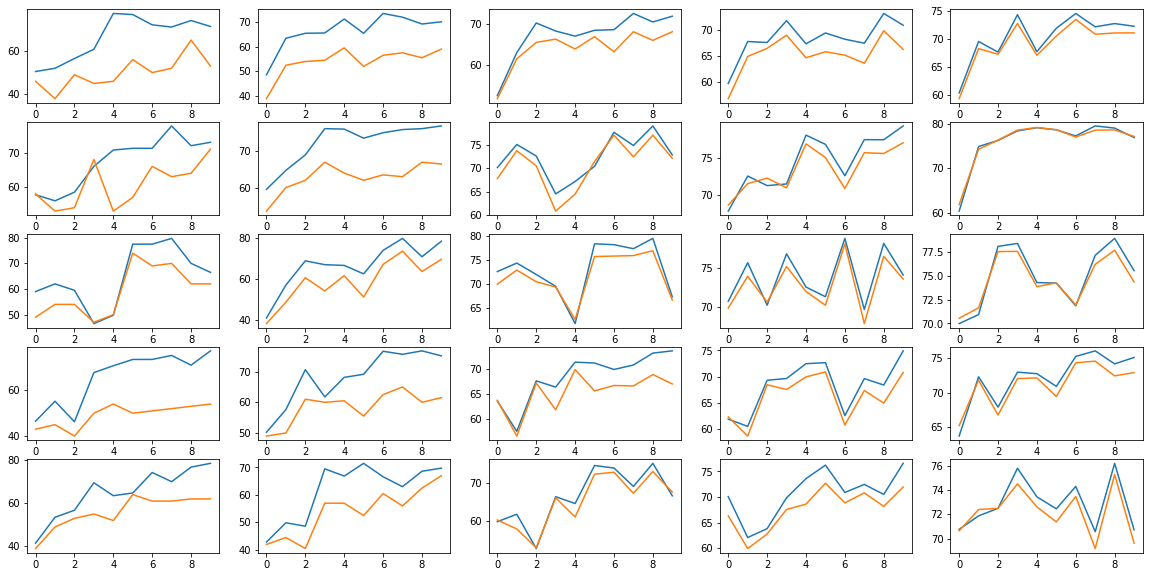

Test accuracy 


Run\Public size 500        1000       5000       10000      25000      | Ensemble acc
0               25.64      26.94      28.74      29.62      30.98      | 32.04      
1               23.18      21.05      22.27      29.32      27.97      | 31.49      
2               18.34      24.70      26.36      22.72      24.96      | 28.11      
3               30.03      30.14      36.46      37.26      38.32      | 39.94      
4               33.63      26.04      28.93      35.69      36.42      | 35.74      

Mean            26.16      25.77      28.55      30.92      31.73     


In [11]:
plot_student_results("cifar10", "feded", settings_ids, [500, 1000, 5000, 10000, 25000], "resnet", "ce", 2)

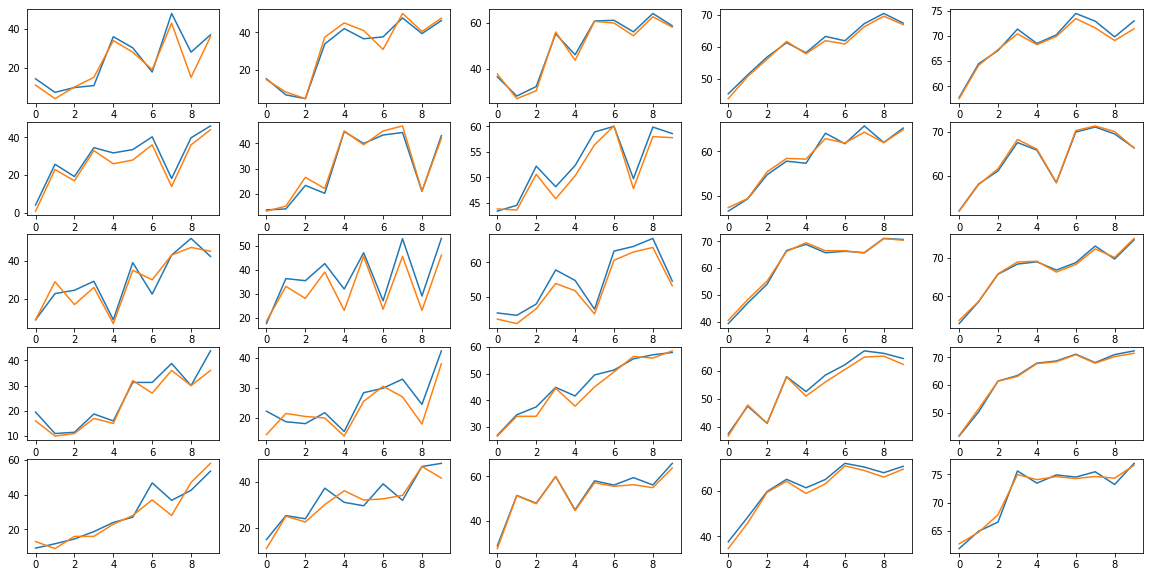

Test accuracy 


Run\Public size 500        1000       5000       10000      25000      | Ensemble acc
0               12.49      16.33      22.83      26.47      26.56      | 31.72      
1               15.31      14.11      19.32      24.20      32.93      | 33.93      
2               13.76      15.28      26.97      25.56      26.44      | 30.01      
3               18.34      17.83      27.99      32.10      34.97      | 39.25      
4               15.73      17.61      24.58      26.35      29.69      | 31.98      

Mean            15.13      16.23      24.34      26.94      30.12     


In [12]:
plot_student_results("cifar10", "feded", settings_ids, [500, 1000, 5000, 10000, 25000], "resnet", "mse", 2)